# 二、数据准备与探索

## 2.1 基于消费明细构建的数据结构

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_excel("/Users/HY/Documents/notebooks/teaching/Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 三、消费者数据的生命周期建模

## 1. 利用python pandas package对模型数据进行清洗

In [2]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date #将时间转换成datetime类型
df = df[pd.notnull(df['CustomerID'])] #去除CustomerID为null数据
df = df[(df['Quantity']>0)]  #去除Quantity<=0的数据
df = df[(df['UnitPrice']>0)] #去除UnitPrice<=0的数据
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]
print(df.head())
print(df.head())
print(df['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
4338


## 2. 利用python lifetime package 对消费者生命周期进行建模

## 2.1 数据探索

In [3]:
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')#计算顾客的消费频次、消费年龄、消费近因等
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


         frequency      recency            T  monetary_value
count  4338.000000  4338.000000  4338.000000     4338.000000
mean      2.864223   130.771554   222.831028      307.028848
std       5.949000   132.210509   117.854570     2612.749850
min       0.000000     0.000000     0.000000        0.000000
25%       0.000000     0.000000   112.000000        0.000000
50%       1.000000    93.000000   248.000000      177.064773
75%       3.000000   252.000000   326.000000      360.162500
max     131.000000   373.000000   373.000000   168469.600000
0.356846473029


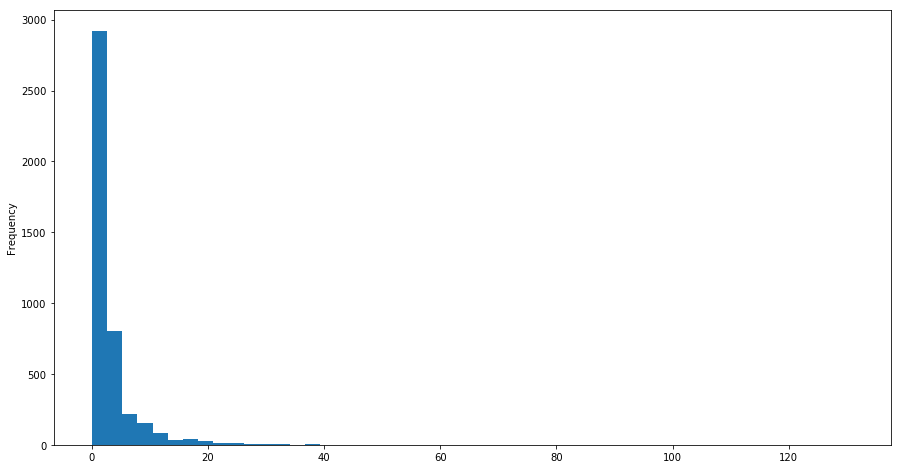

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0) 

data['frequency'].plot(kind='hist', bins=50)#展示频率分布情况
print(data.describe())
print(sum(data['frequency'] == 0)/float(len(data)))

## 2.2 基于BG/NBD的Frequency/Recency的分析来判断消费者与品牌的亲密性

In [5]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0) # 创建模型对象,不同的penalty参数调整来控制不同的假设中概率的参数设定，一般控制在0.001～0.1
bgf.fit(data['frequency'], data['recency'], data['T']) #对模型进行预测
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.94, b: 2.11, r: 0.83>


### 2.2.1可视化Frequency/Receny矩阵

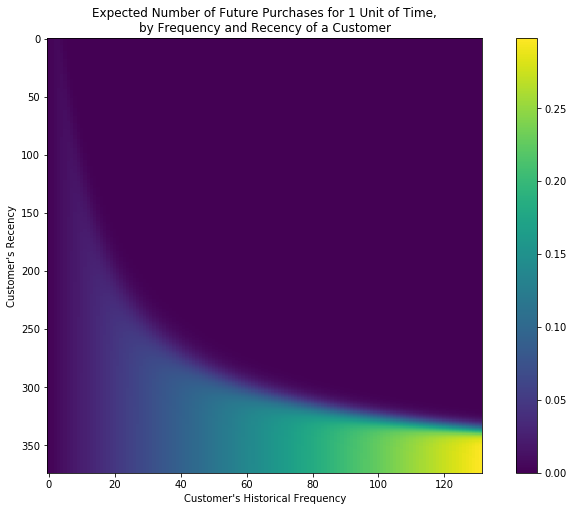

In [6]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf) #用可视化的方法描绘不同人群在品牌下个时间节点的存活概率

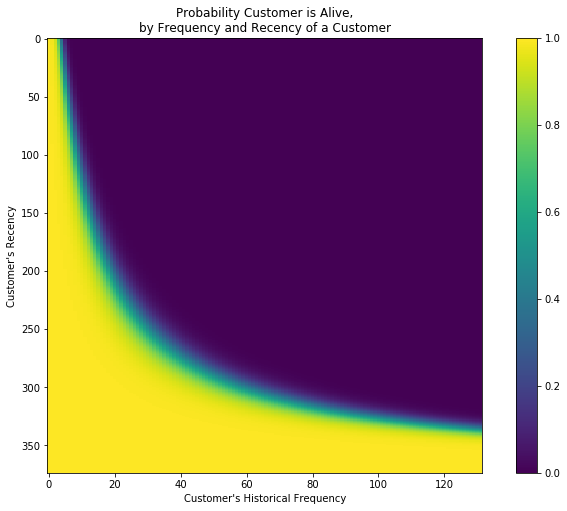

In [7]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)#预测活跃客户

### 2.2.2 预测活跃用户在一定单位时间内的购买概率

In [8]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])#预测在下一个周期T的购买的高绿
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.200987
15311.0,89.0,373.0,373.0,677.729438,0.203250
17841.0,111.0,372.0,373.0,364.452162,0.253029
12748.0,112.0,373.0,373.0,301.024821,0.255293
14911.0,131.0,372.0,373.0,1093.661679,0.298284


In [9]:
t = 30
#对每个消费者进行30天的购买频次预测
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,6.029359
15311.0,89.0,373.0,373.0,677.729438,6.097257
17841.0,111.0,372.0,373.0,364.452162,7.590567
12748.0,112.0,373.0,373.0,301.024821,7.658471
14911.0,131.0,372.0,373.0,1093.661679,8.948140


### 2.2.3 模型的评估

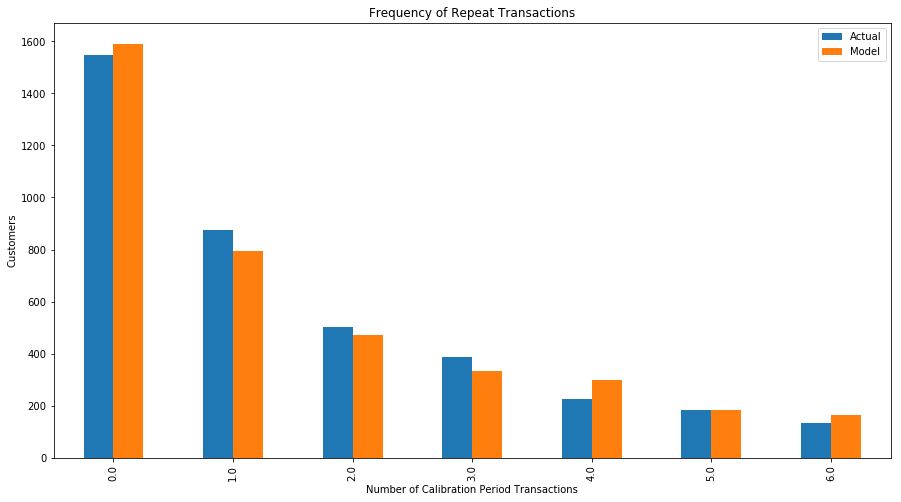

In [10]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [14]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   #拆分数据：样本期、验证期
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                  184  
12347.0                  184  
12348.0                  184  
12350.0                  184  
12352.0                  184  


In [19]:
import numpy as np
from matplotlib import *

rmse_train_count = (summary_cal_holdout['frequency_holdout'] - summary_cal_holdout['frequency_cal']).apply(lambda x : x*x)
rmse_train_count = np.sqrt(rmse_train_count.sum()/len(data))
print('RMSE =', rmse_train_count)

RMSE = 1.96939468998


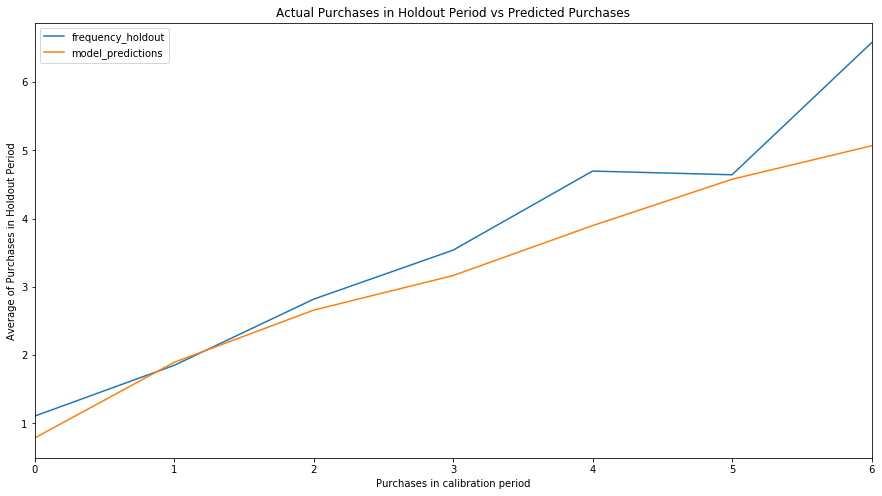

In [27]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])#预测验证期数据
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### 2.2.4 消费者历史的回溯来看生存概率

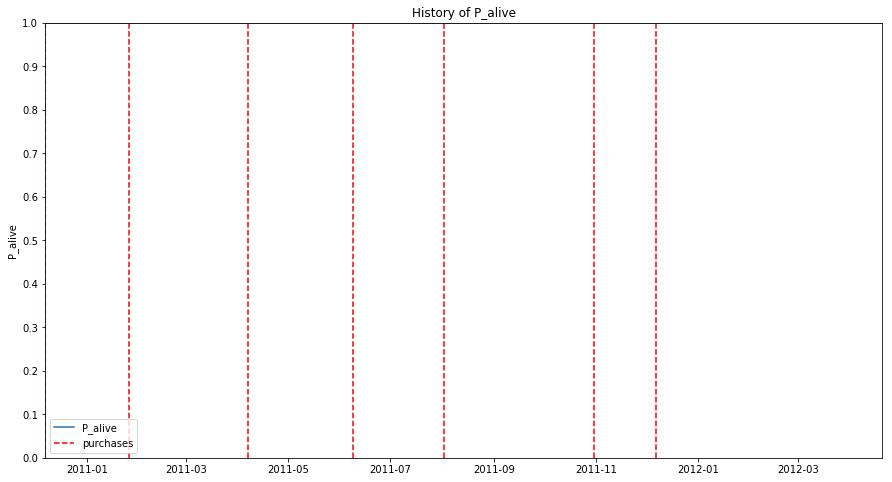

In [43]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
id = 12347
days_since_birth = 500
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')#计算客户存活的历史概率

## 2.3 基于GAMMA GAMMA模型对客户价值预测以衡量其品牌消费力

In [25]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.469688
12348.0           3.0    283.0  358.0      301.480000             0.268710
12352.0           6.0    260.0  296.0      368.256667             0.560959
12356.0           2.0    303.0  325.0      269.905000             0.215156
12358.0           1.0    149.0  150.0      683.200000             0.250139
2790


In [26]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)#创建模型对象,不同的penalty参数调整来控制不同的假设中概率的参数设定
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])#模型拟合
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.89>


In [47]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))#计算消费者平均每笔交易金额

CustomerID
12346.0    416.946001
12347.0    569.978834
12348.0    333.784225
12349.0    416.946001
12350.0    416.946001
12352.0    376.175354
12353.0    416.946001
12354.0    416.946001
12355.0    416.946001
12356.0    324.039406
dtype: float64


In [ ]:
t = 90
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])#预测客户在下一个周期T购买的频次

In [49]:
print(416.94 * 1.4054323465114449)

585.9809625544818
